<h1>Removing Artifacts From Mammograms</h1>

This notebook is written to explain the process I use to segment the artificial artifacts (number plates, orientation demarcation) from the actual breast tissue in mammogram images from the MIAS and DDSM data sets.

Given the thresholding constraint of human input into the process, I may migrate this code to UI-interface for segmentation. 

Youqing will discuss further to decide on merit of this process, improvements to the algorithm, additional components that may be integrated.

In [1]:
__version__   = '0.0.1'
__status__    = 'Development'
__date__      = '2017-March-12'
__author__    = 'Jay Narhan'

In [2]:
import os
import cv2
import copy
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline

---
<h2>Read in Some Images to Work With</h2>

In [3]:
CURR_DIR = os.getcwd()

# I have some test images as PNGs, scaled to 200 width by X height (where X preserves 
# the aspect ratio of the image):
IMG_DIR = '../../Test_PNGs/' 

filenames = [ filename for filename in os.listdir(IMG_DIR) if filename.endswith('.png')]

In [4]:
images = []
os.chdir(IMG_DIR)
for filename in filenames:
    img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
    images.append(img)
os.chdir(CURR_DIR)

print "Number of images in memory: {}".format( len(images))

Number of images in memory: 15


For the example image in this notebook, set a global var:

In [5]:
IMG_NUM = 0

---
<h2>Preprocess Images</h2>

<h3>Image Enhancement via Equalization</h3>

Some exploratory work to understand the distribution of grayscale  pixel values in the mammograms:

Many of the images are severely skewed containing a lot of pixel values corresponding to black. Some of the images however have bi-modal distributions where the breast grayscale values are also quite large.

Notice that the contrast within the breast tissue in mammograms is also quite low (making it hard to distinguish structures).

In [6]:
def get_hists(image, b):
    hist, bins = np.histogram(img.flatten(), bins=b, range=[0,255])
    cdf = hist.cumsum()
    cdf_normalized = cdf *hist.max()/ cdf.max()
    
    return [hist, cdf_normalized]

def plot(img, img_hists):
    plt.figure(1)
    plt.subplot(121)
    plt.imshow(img, cmap='gray')
    
    plt.subplot(122)
    plt.plot(img_hists[1], color = 'b')
    plt.plot(img_hists[0], color = 'r')
    plt.xlim([0,256])
    plt.legend(('cdf','histogram'), loc = 'upper left')
    
    plt.subplots_adjust(top=0.92, bottom=0.08,
                        left=0.10, right=0.95,
                        hspace=0.25, wspace=0.35)

Example of a mammogram image that I will work with in this notebook:

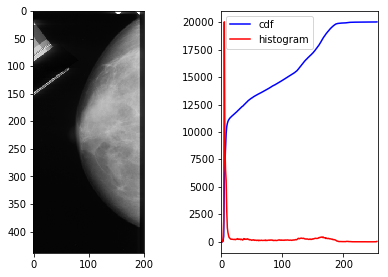

In [7]:
img = images[IMG_NUM]
img_hists = get_hists( img, b=256)

plot(img, img_hists)

Equalization attempts to correct for poor contrast in images. It is commonly used in medical imaging problems. The process looks to better distribute intensities of pixel values through the image.

**Contrast Limited Adaptive Histogram Equalization (CLAHE)**

Ordinary histogram equalization and adaptive equalization for mammograms have been noted as overly enhancing noise and sharp regions in such images. CLAHE has been found to be a more effective strategy to use.

In [8]:
clahe_images = []
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
for i, image in enumerate(images):
    clahe_images.append( clahe.apply(image))

Example continued:

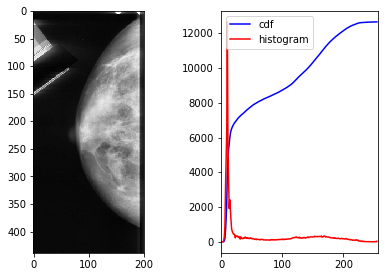

In [9]:
img = clahe_images[IMG_NUM]
img_hists = get_hists( img, b=256)

plot(img, img_hists)

This process works well for enhancing contrast within the image. The structures within the breast tissue are enhanced, as is the location of the nipple (look at IMG_NUM=0).

<h3>Thresholding</h3>

This section aims is the crux of the objective at hand. It aims to segment the breast from the artifacts within the mammogram. Note that as an automated heuristic for thresholding, I used the median pixel value within the mammogram.

There may be an aspect of having to visual preview the resulting binary image in order to tweak the appropriate threshold value to use. Perhaps there is a better heuristic, but I'm finding that the non-standard structure of mammograms makes it very hard to avoid a human eye in this process.

In [10]:
images_thresh = []
for i, image in enumerate(clahe_images):
    images_thresh.append( cv2.threshold(image, np.median(image), 255, cv2.THRESH_BINARY)[1]) # just the binary image

Example continued:

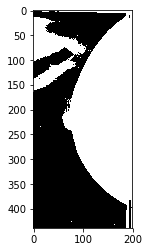

In [11]:
plt.imshow(images_thresh[IMG_NUM], cmap='gray')

The general idea now is to now count the pixels that belong to the breast tissue (in most cases, this will be the largest group of contiguous cells that have pixel value equal to 1 (white)). 

With that information in hand, we can retain the breast object by some funky multiplication of the original or CLAHE image as follows:

In [12]:
regions = []
for i, image in enumerate( images_thresh):
    _, l, s, _ = cv2.connectedComponentsWithStats(images_thresh[i])
    # labels: contiguous regions in mammogram, labelled
    # stats: count of pixels in each discrete object
    regions.append( {'labels':l, 'count':s[:, -1]} )

Example of contents of the returned data structure ('regions'):

Using the thresholded image of our example (as shown above).

In [13]:
print "Labelled discrete regions: {}".format ( set(regions[IMG_NUM]['labels'].flatten()))
print "Count of pixels in first 5 regions: {}".format( regions[IMG_NUM]['count'][0:5, ])

Labelled discrete regions: set([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37])
Count of pixels in first 5 regions: [44472 36432  6833     1     2]


---
This is the stage that definitely requires a human eye. 

The index to the 'count' component needs to be selected. This index corresponds to the region we wish to retain (breast). In many cases the value of this index will be 1 as a black background will predominate. However, sometimes the breast itself may make up most the image, in which case the value to send to the function will be 0. Typically the value is between 0-2.

In [14]:
def mask(image, labels, region):
    labels = copy.deepcopy(labels)  # create a full, unique copy of labels
    for row in range(image.shape[0]):
        for col in range(image.shape[1]):
            if labels[row, col] != region:
                labels[row, col] = 0  # mask the artifact
            else:
                labels[row, col] = 1  # retain the breast
    return labels

Example continued:

The region to retain is visually determined as being region 1: black predominates (region =0), the breast area is the second largest object (region=1), so the region sent to the mask function is '1'.

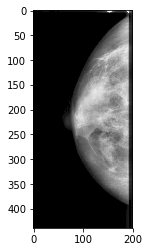

In [15]:
my_mask = mask( images_thresh[IMG_NUM], regions[IMG_NUM]['labels'], region=1)
image = clahe_images[IMG_NUM] * my_mask  # notice I'm using the CLAHE image, you could use the original
plt.imshow(image, cmap='gray')